In [5]:
import numpy as np
import pandas as pd
import os

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications import MobileNetV2

#Image generation et preptraitement
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Analyse des performaces et résultat
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Partie Analyse Dataset

In [6]:
#Accéder au dossier principale du dataset
DIR = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
#Accéder a chaque folder et stocker le nom de folder dans classes
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [7]:
#Séparer Le GT folder de notre analyse

label = []
path = []

for dirname, _,filenames in os.walk(DIR):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # Si le nom contient .png
            if dirname.split()[-1]!='GT':                       
                label.append(os.path.split(dirname)[-1])         # Ajouter le nom du répertoire au label
                path.append(os.path.join(dirname,filename))     # Ajouter tous les png au chemin de repertoire
# Creation de datafram
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [8]:
df.head(10)

path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
5  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
6  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
7  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
8  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
9  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

In [9]:
df.path[3]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00237.png'

In [10]:
#Résumé du Dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [11]:
#Afficher le nombre d'occurrences de chaque étiquette dans la colonne 'label'

df['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

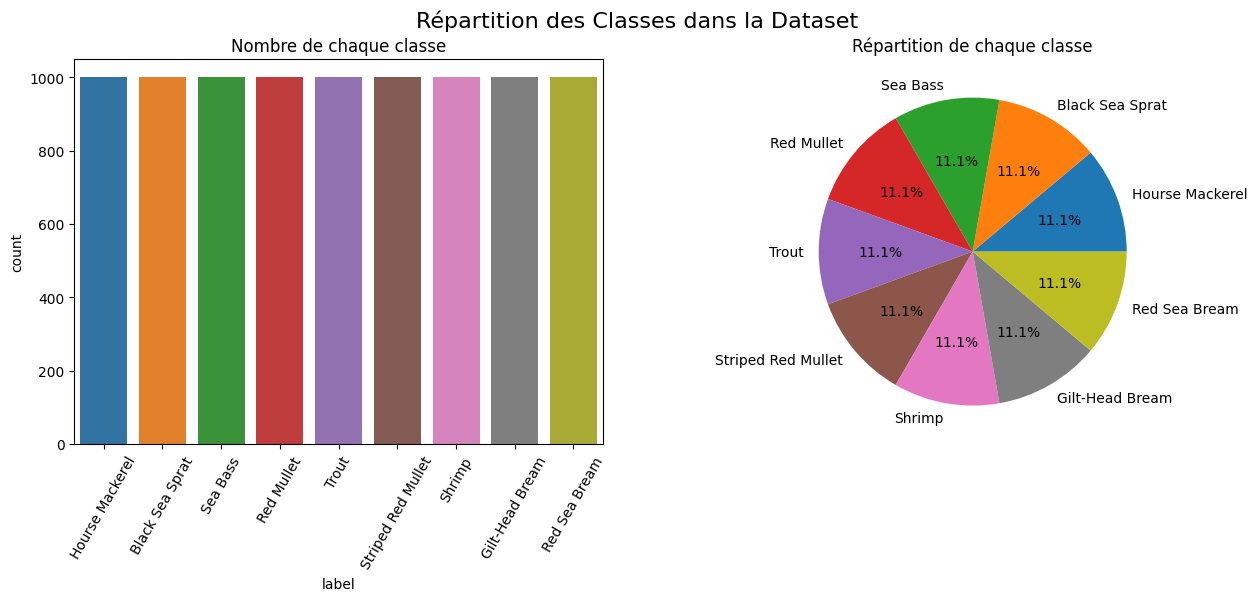

In [12]:
#Visualisation de Dataset ( Repartition des class dans le dataset)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='label')
plt.xticks(rotation=60)
plt.title('Nombre de chaque classe')

plt.subplot(1, 2, 2)
plt.pie(x=df['label'].value_counts().values, labels=df['label'].value_counts().index, autopct='%1.1f%%')
plt.title('Répartition de chaque classe')

plt.suptitle('Répartition des Classes dans la Dataset', size=16)
plt.show()


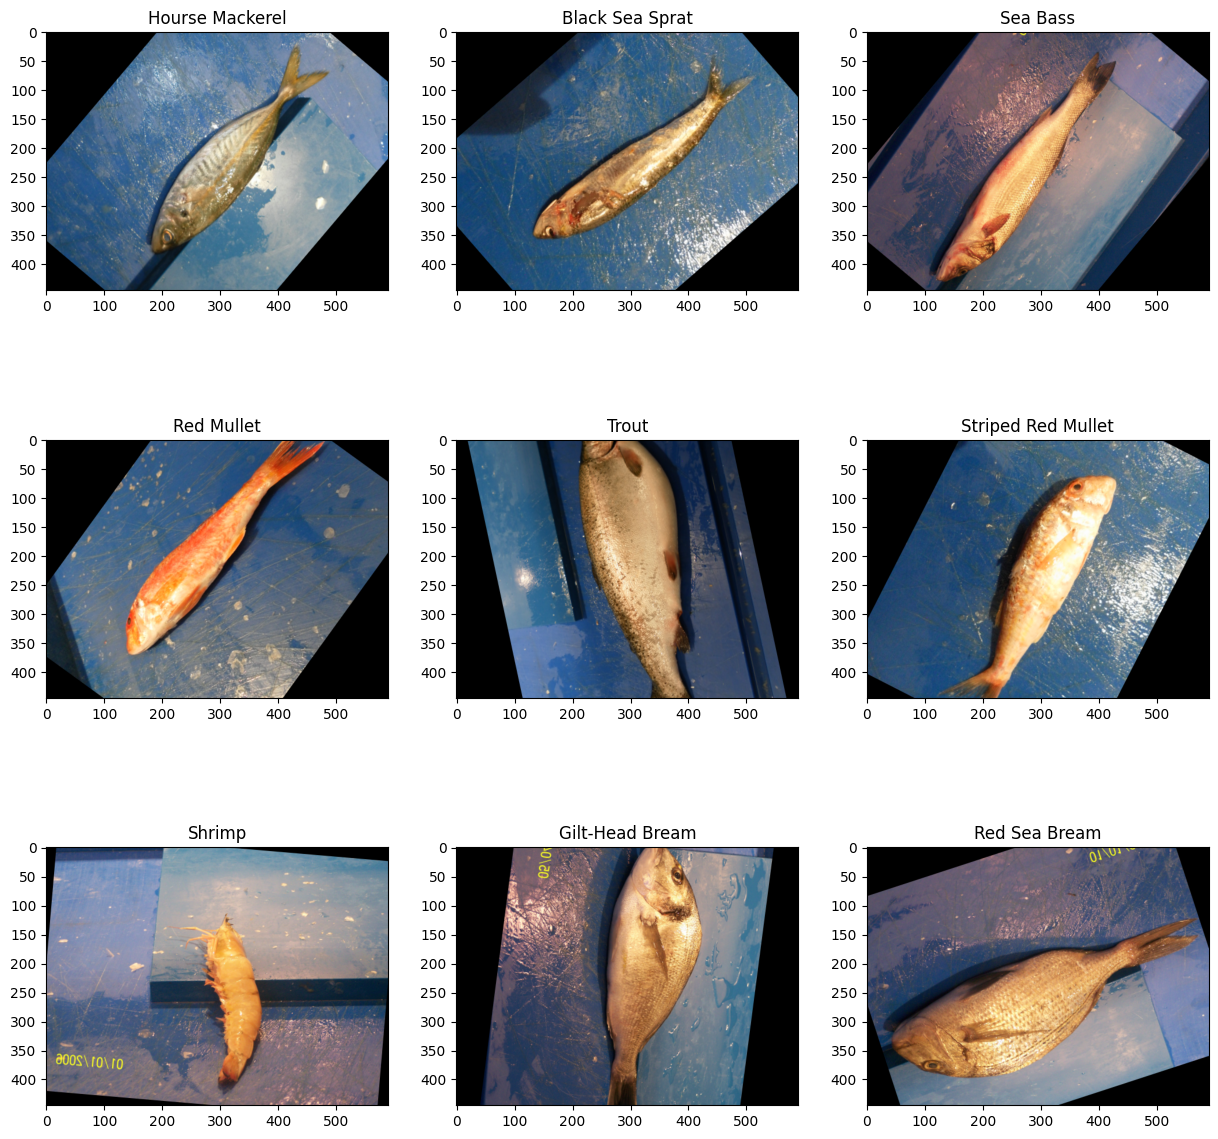

In [13]:
#Affichage d la 5éme image de chaque classe
idx = 0
plt.figure(figsize=(15,15))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[5,0]))
    plt.title(unique_label)
   # plt.axis('off')
    idx+=1

## Partie séparation de dataset et prétraitement des données

In [15]:
#Séparation de Données de test et de l'entrainement 
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [16]:
#Affichage de dimension de datFram train et celle du test
print(train_df.shape)
print(test_df.shape)

(7200, 2)
(1800, 2)


## Partie Géneration des image et prétraitement

In [17]:
#Utiliser ImageDataGenerator de Keras pour prétraiter nos images avec notre modèle 
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [19]:
display("train",train_images.class_indices)
display("validation",val_images.class_indices)
display("test",test_images.class_indices)

'train'

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

'validation'

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

'test'

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

AttributeError: 'DataFrameIterator' object has no attribute 'next'

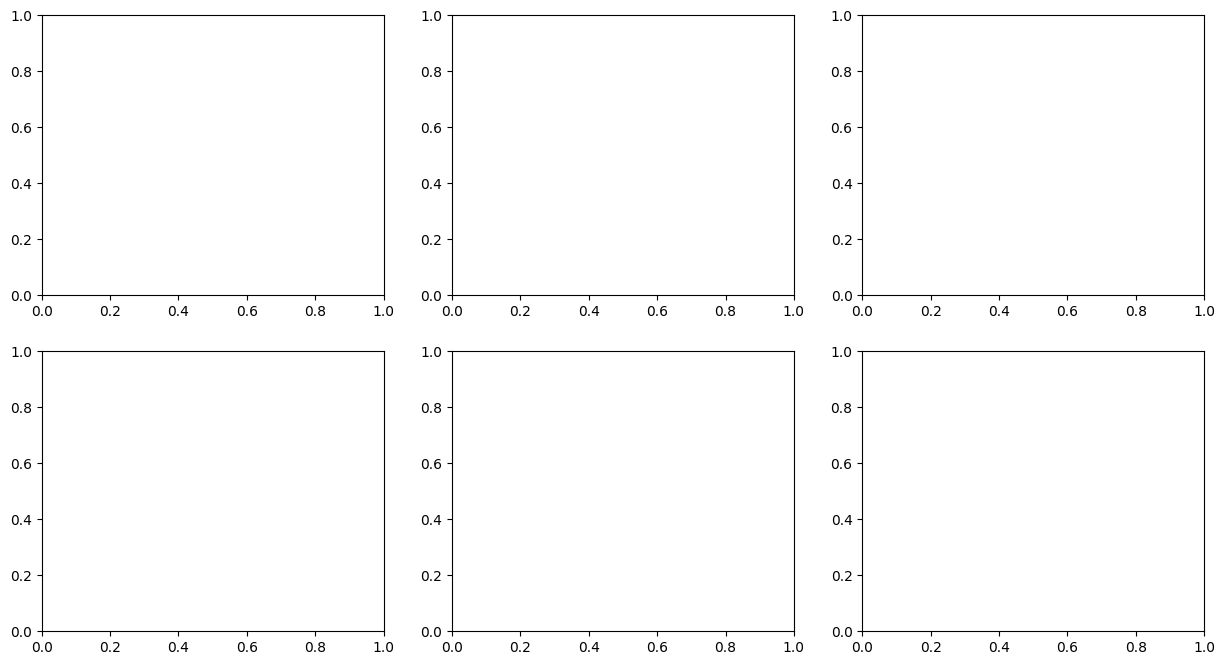

In [20]:
#Affichage des images aprés le prétraitement

fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = test_images.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    j=j+1

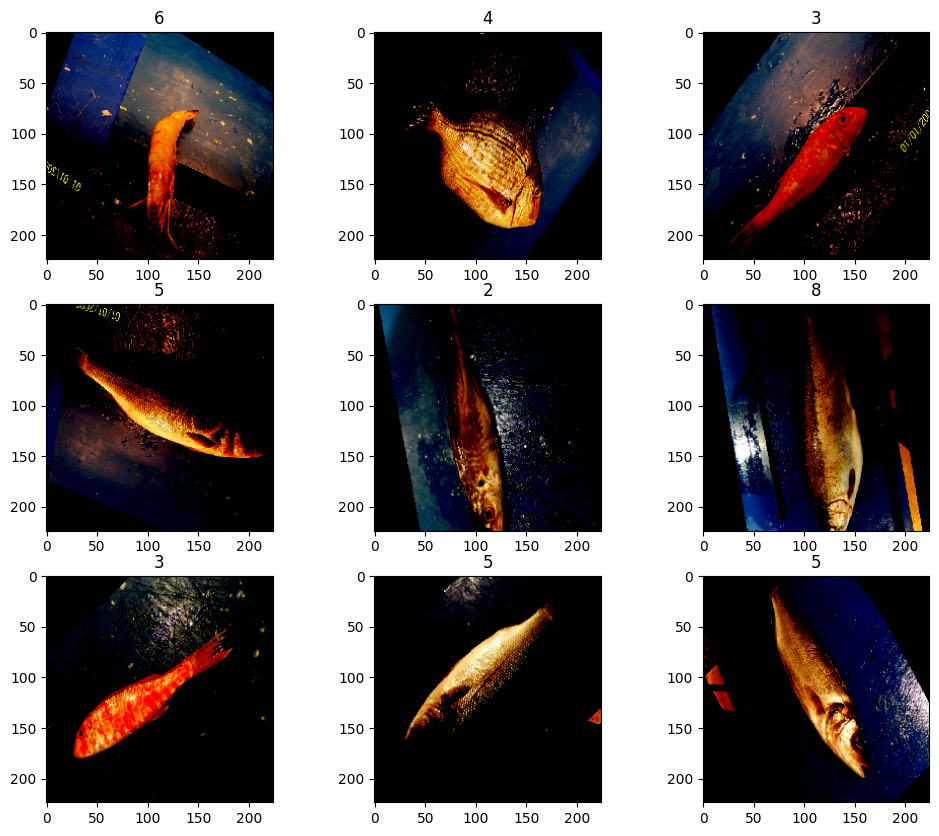

In [22]:
#Affichage des images aprés le prétraitement
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
ax = ax.flatten()

# Utiliser DataFrameIterator directement dans la boucle
for (img, labels), ax in zip(test_images, ax):
    ax.imshow(img[0])
    ax.set_title(np.argmax(labels[0]))  

plt.show()


## Partie entrainement du modéle

In [23]:
#Importer le modéle MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
#Creer les input du modéle et les couches necessaire pour effectuer notre tache
import warnings
warnings.filterwarnings("ignore")

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,439,625 (9.31 MB)

 Trainable params: 181,641 (709.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8483 - loss: 0.4997 - val_accuracy: 0.9951 - val_loss: 0.0189
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9992 - loss: 0.0090 - val_accuracy: 0.9965 - val_loss: 0.0131
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9965 - val_loss: 0.0079
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 1.0000 - loss: 8.1437e-04 - val_accuracy: 0.9965 - val_loss: 0.0072
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 1.0000 - loss: 5.1281e-04 - val_accuracy: 0.9972 - val_loss: 0.0070


In [40]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00562
Test Accuracy: 99.83%


In [41]:
model.save('1rst-model-yas.h5')

In [42]:
history_df=pd.DataFrame(history.history)
history_df

accuracy      loss  val_accuracy  val_loss
0  0.950347  0.173535      0.995139  0.018916
1  0.998785  0.009861      0.996528  0.013149
2  1.000000  0.002637      0.996528  0.007917
3  1.000000  0.000794      0.996528  0.007221
4  1.000000  0.000491      0.997222  0.007017

In [43]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 899ms/step


In [44]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [45]:
# Visualiser  pred_df
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

path               label  \
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Gilt-Head Bream   
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Black Sea Sprat   
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Hourse Mackerel   
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...               Trout   
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
5  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
6  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   
7  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
8  /kaggle/input/a-large-scale-fish-dataset/Fish_...          Red Mullet   
9  /kaggle/input/a-large-scale-fish-dataset/Fish_...               Trout   

                 pred  
0     Gilt-Head Bream  
1     Black Sea Sprat  
2     Hourse Mackerel  
3               Trout  
4       Red Sea Bream  
5       Red Sea Bream  
6  Striped Red Mullet  
7       Red Sea Bream  
8          Red Mullet  
9               Trout

In [46]:
# affichage des prédictions incorrectes
pred_df[pred_df['label']!=pred_df['pred']]

path               label  \
1354  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
1604  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   
1629  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   

                 pred  
1354  Gilt-Head Bream  
1604           Shrimp  
1629           Shrimp

In [47]:
pred_df.path[1354]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/00236.png'

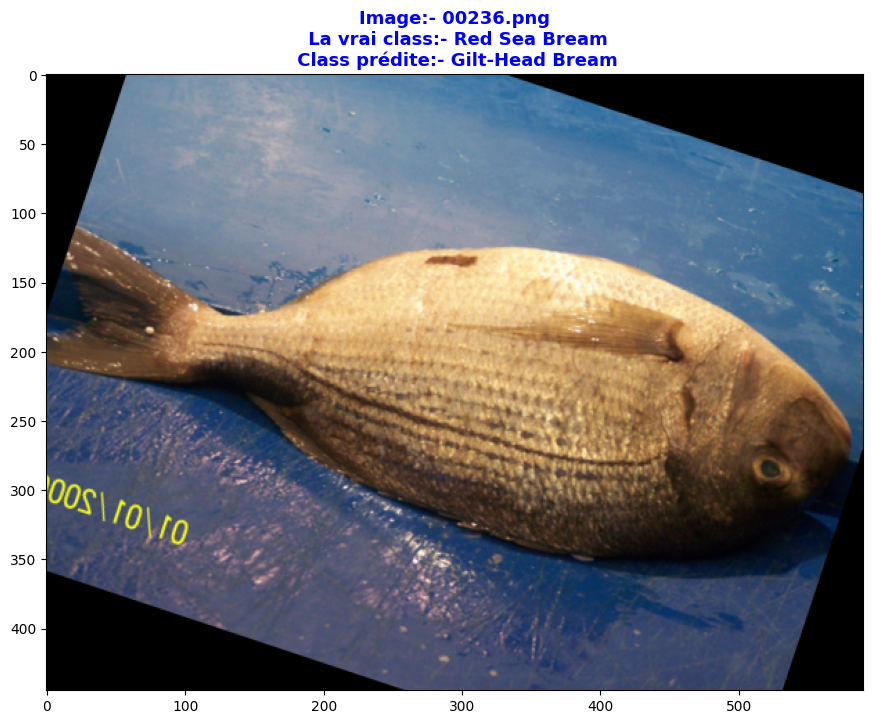

In [48]:
# test sur une fausse prédiction
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[1354]))
title1 = pred_df.path[1354].split('/')[-2]
title2 = pred_df.path[1354].split('/')[-1]
title3 = pred_df.pred[1354]
plt.title(f'Image:- {title2}\n La vrai class:- {title1}\n Class prédite:- {title3}', color = 'b', weight = 'bold', fontsize = 13)
plt.show()

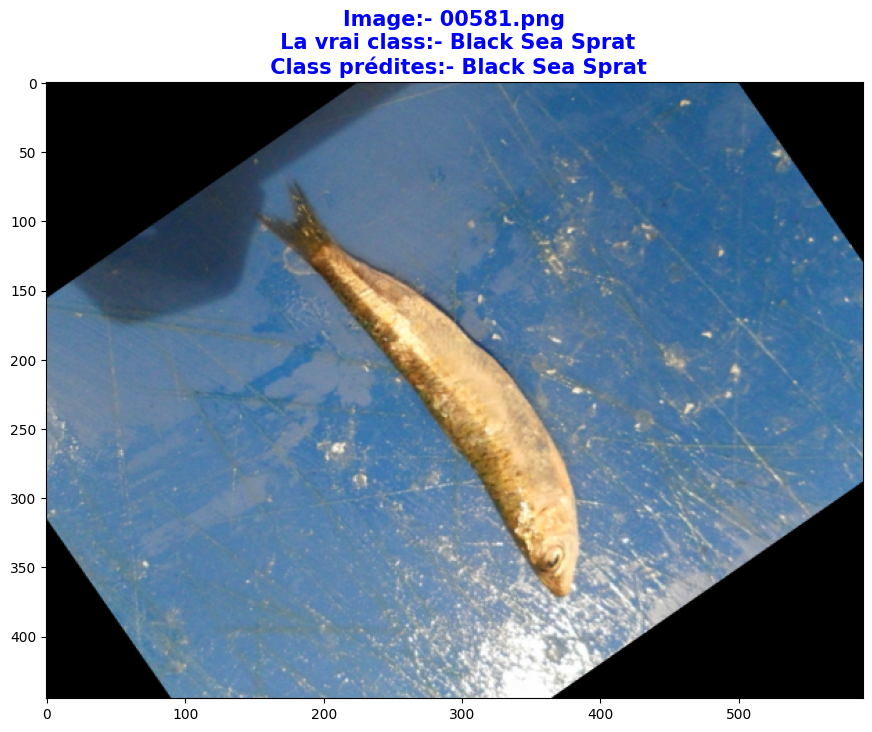

In [49]:
# test sur une bonne prédiction
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[1609]))
title1 = pred_df.path[1609].split('/')[-2]
title2 = pred_df.path[1609].split('/')[-1]
title3 = pred_df.pred[1609]
plt.title(f'Image:- {title2}\n La vrai class:- {title1}\n Class prédites:- {title3}', color = 'b', weight = 'bold', fontsize = 15)
plt.show()

Accuracy Score: 0.9983333333333333


<Axes: >

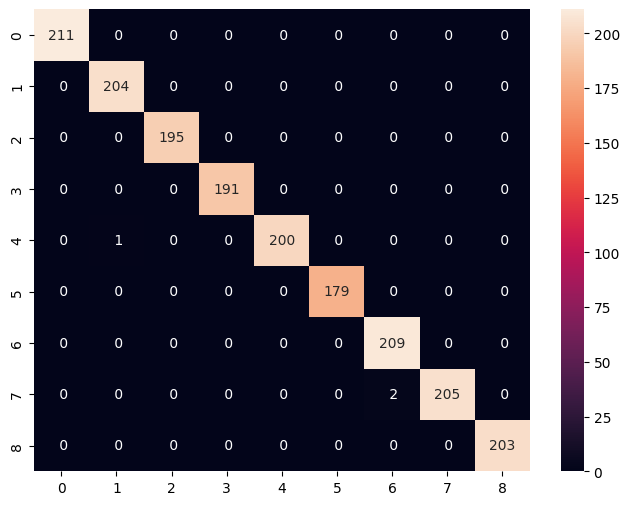

In [50]:
#Matrice de confusion et précision
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

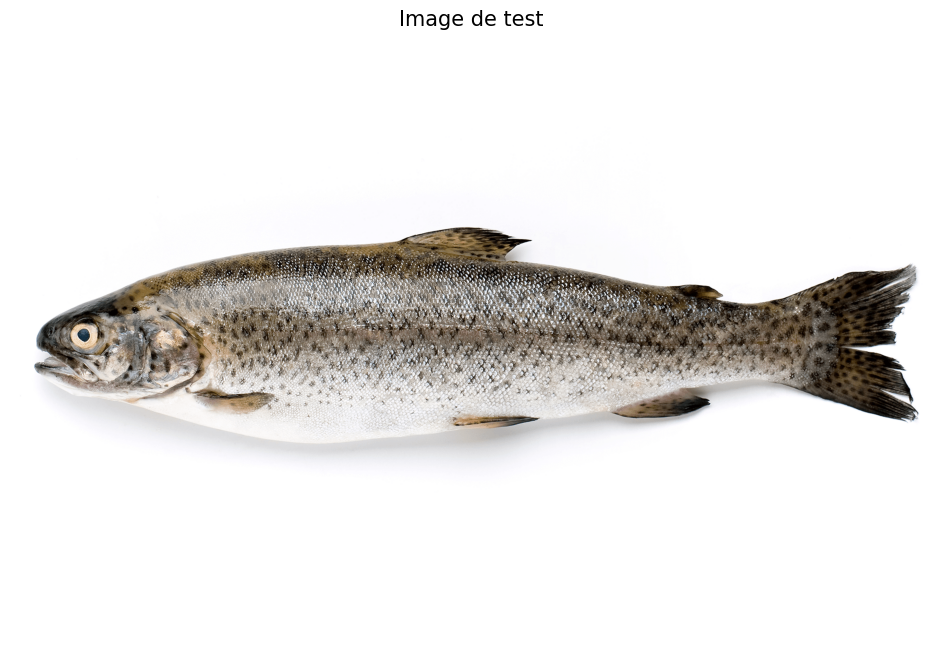

In [51]:
import matplotlib.pyplot as plt

# Chemin vers l'image locale
image_path = "/kaggle/input/datasett/test.png"

# Charger l'image
image = plt.imread(image_path)

# Afficher l'image
plt.figure(figsize=(15,8))
plt.imshow(image)
plt.title('Image de test', fontsize=15)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


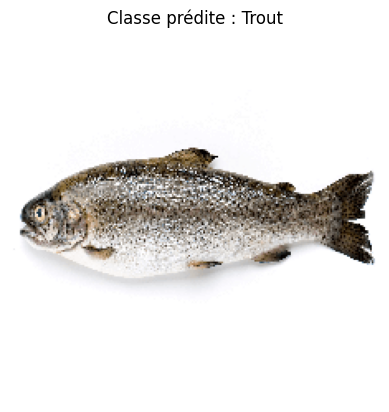

In [52]:

from tensorflow.keras.preprocessing import image


# Charger le modèle pré-entraîné
model = tf.keras.models.load_model('/kaggle/working/1rst-model-yas.h5')

# Charger notre image à tester
image_path = "/kaggle/input/datasett/test.png"
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Effectuer la prédiction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Afficher le résultat de la prédiction
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
predicted_class_name = class_names[predicted_class]

# Afficher l'image avec la classe prédite
plt.imshow(img)
plt.title(f'Classe prédite : {predicted_class_name}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classe prédite : Sea Bass
Probabilité de prédiction: 0.82


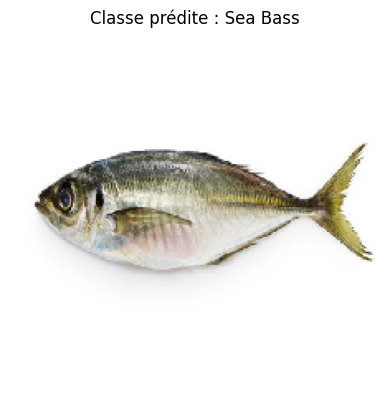

In [53]:
from tensorflow.keras.preprocessing import image

# Charger le modèle pré-entraîné
model = tf.keras.models.load_model('/kaggle/working/1rst-model-yas.h5')

# Charger une image à tester
image_path = "/kaggle/input/datasett2/Image2.jpg"
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Effectuer la prédiction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Afficher le résultat de la prédiction
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
predicted_class_name = class_names[predicted_class]

predicted_prob = prediction[0][predicted_class]

# Afficher l'image avec la classe prédite
print(f'Classe prédite : {predicted_class_name}')
print(f'Probabilité de prédiction: {predicted_prob:.2f}')

plt.imshow(img)
plt.title(f'Classe prédite : {predicted_class_name}')

plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


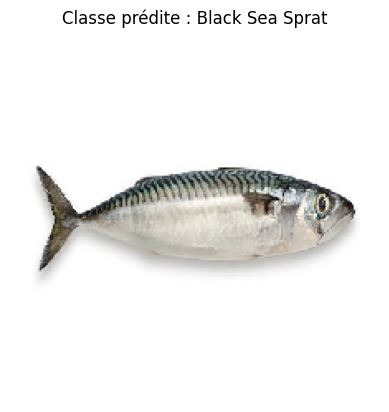

In [54]:
from tensorflow.keras.preprocessing import image


# Charger le modèle pré-entraîné
model = tf.keras.models.load_model('/kaggle/working/1rst-model-yas.h5')

# Charger l'image 
image_path = "/kaggle/input/datasett3/Image3.jpg"
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Effectuer la prédiction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Afficher le résultat de la prédiction
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
predicted_class_name = class_names[predicted_class]

# Afficher l'image avec la classe prédite
plt.imshow(img)
plt.title(f'Classe prédite : {predicted_class_name}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


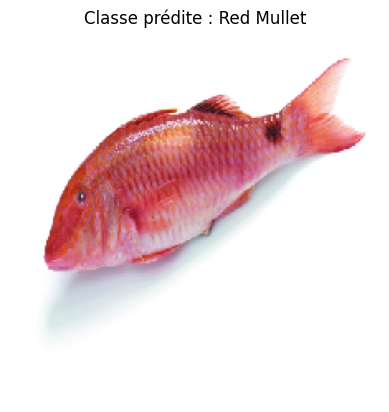

In [55]:
from tensorflow.keras.preprocessing import image


# Charger le modèle pré-entraîné
model = tf.keras.models.load_model('/kaggle/working/1rst-model-yas.h5')

# Charger une image à tester
image_path = "/kaggle/input/datasett4/Image4.jpg"
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Effectuer la prédiction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Afficher le résultat de la prédiction
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
predicted_class_name = class_names[predicted_class]

# Afficher l'image avec la classe prédite
plt.imshow(img)
plt.title(f'Classe prédite : {predicted_class_name}')
plt.axis('off')
plt.show()

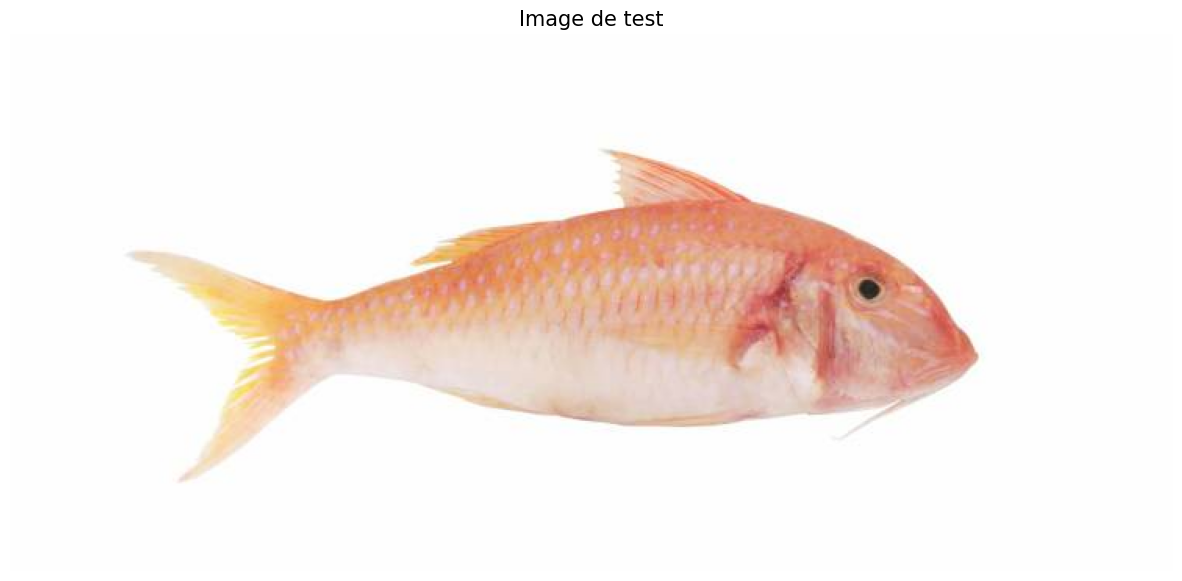

In [67]:
import matplotlib.pyplot as plt

# Chemin vers l'image locale
image_path = "/kaggle/input/datasett5/Image5.jpg"

# Charger l'image
image = plt.imread(image_path)

# Afficher l'image
plt.figure(figsize=(15,8))
plt.imshow(image)
plt.title('Image de test', fontsize=15)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Probabilité de prédiction: 0.83


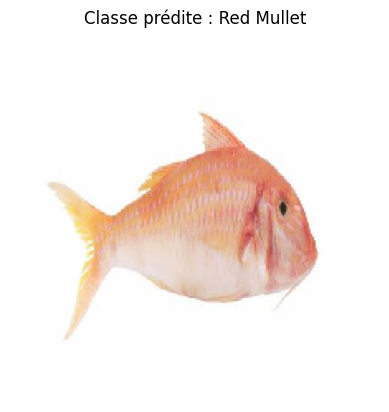

In [56]:
from tensorflow.keras.preprocessing import image


# Charger le modèle pré-entraîné
model = tf.keras.models.load_model('/kaggle/working/1rst-model-yas.h5')

# Charger une image à tester
image_path = "/kaggle/input/datasett5/Image5.jpg"
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Effectuer la prédiction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Afficher le résultat de la prédiction
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
predicted_class_name = class_names[predicted_class]
predicted_prob = prediction[0][predicted_class]
# Afficher l'image avec la classe prédite
plt.imshow(img)
plt.title(f'Classe prédite : {predicted_class_name}')
print(f'Probabilité de prédiction: {predicted_prob:.2f}')
plt.axis('off')
plt.show()

In [57]:
#afficher le rapport de classification
print(classification_report(pred_df['label'],pred_df['pred']))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       211
   Gilt-Head Bream       1.00      1.00      1.00       204
   Hourse Mackerel       1.00      1.00      1.00       195
        Red Mullet       1.00      1.00      1.00       191
     Red Sea Bream       1.00      1.00      1.00       201
          Sea Bass       1.00      1.00      1.00       179
            Shrimp       0.99      1.00      1.00       209
Striped Red Mullet       1.00      0.99      1.00       207
             Trout       1.00      1.00      1.00       203

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800

